In [1]:
# %load /home/chenao/pre.py
import numpy as np
import matplotlib as mpl
mpl.rcParams['figure.dpi']=300
import matplotlib.pyplot as plt
from astropy.io import fits
from galpy.orbit import Orbit
import astropy.units as u
from astropy.coordinates import Galactocentric, ICRS, SkyCoord
import astropy.coordinates as coord
from astropy.coordinates import ICRS,Galactic
from scipy.stats import binned_statistic_2d
import pandas as pd
from astropy.coordinates import CartesianDifferential
from astropy.table import Table
import time
from galpy.potential import MWPotential2014
from galpy.potential.mwpotentials import McMillan17, Irrgang13I, DehnenBinney98I
from galpy.util.bovy_conversion import get_physical, physical_compatible
import statsmodels.api as sm
from matplotlib import patches
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.odr import ODR, Model, Data, RealData
import seaborn as sns
from galpy.potential import MWPotential2014
from scipy.stats import gaussian_kde
import scipy.ndimage as ndimage

def hist2d(fig,ax,xdata,ydata,zdata,stat='count',lognorm=False,vmin=1,vmax=1e4,xbin=100,ybin=100,cmap='viridis',cbar=False,*args,**kwargs):
    '''
    ax
    xdata
    ydata
    zdata
    stat='count'
    '''
    if 'xmin' and 'ymin' and 'xmax' and 'ymax' in kwargs.keys():
        xedges = np.linspace(kwargs['xmin'], kwargs['xmax'], xbin+1)
        yedges = np.linspace(kwargs['ymin'], kwargs['ymax'], ybin+1)
        twod_array = binned_statistic_2d(xdata,ydata,zdata,statistic=stat,bins=[xedges, yedges])[0].T
        if lognorm == True:
            norm = mpl.colors.LogNorm(1, 10000)
            im = ax.imshow(twod_array,
                           origin='lower',
                           cmap=cmap,
                           aspect='auto',
                           norm = norm,
                           extent=[kwargs['xmin'], kwargs['xmax'], kwargs['ymin'], kwargs['ymax']])      
        else:
            im = ax.imshow(twod_array,origin='lower',cmap=cmap,aspect='auto',extent=[kwargs['xmin'], kwargs['xmax'], kwargs['ymin'], kwargs['ymax']])      
    else:
        xmin = min(xdata)
        xmax = max(xdata)
        ymin = min(ydata)
        ymax = max(ydata)  
        xedges = np.linspace(xmin, xmax, xbin+1)
        yedges = np.linspace(ymin, ymax, ybin+1)
        twod_array = binned_statistic_2d(xdata,ydata,zdata,statistic=stat,bins=[xedges, yedges])[0].T
        
        if lognorm == True:
            norm = mpl.colors.LogNorm(vmin=vmin,vmax=vmax)
            im = ax.imshow(twod_array,origin='lower',cmap=cmap,aspect='auto',extent=[xmin, xmax, ymin, ymax],norm=norm)     
        else:
            im = ax.imshow(twod_array,origin='lower',cmap=cmap,aspect='auto',extent=[xmin, xmax, ymin, ymax])     

    # add axes labels
    if 'xlabel' in kwargs.keys():
        ax.set_xlabel('{}'.format(kwargs['xlabel']),fontsize=15)
    if 'ylabel' in kwargs.keys():
        ax.set_ylabel('{}'.format(kwargs['ylabel']),fontsize=15)
       
    # add colorbar
    if cbar == True:
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.00)

        if lognorm == True:
            cbar = fig.colorbar(im,ax=ax,shrink=0.8,norm=norm,
                                cax=cax,orientation = 'vertical')
        else:
            cbar = fig.colorbar(im,ax=ax,shrink=0.8,
                                cax=cax,orientation = 'vertical')
        if 'zlabel' in kwargs.keys():
            font = {'size':15}
            cbar.set_label(kwargs['zlabel'],fontdict=font)
    return im
def plot_contour(ax, x,y,xy_range,bins=100,lognorm=True,colorl="red",cmapl='RedBu',cmap="Blues",zorderl=1,levels=[50,500],hist=True,):
    XX, YY, H = create_median_map(x,y,
                              xy_range=xy_range,
                              weights=None,
                              bins=bins)
    lognorm=mpl.colors.LogNorm(vmin=1,vmax=5e3)
    if  hist:
        #ax.pcolor(XX, YY, H.T, cmap=cmap, norm=lognorm,zorder=-1)
        ax.hist2d(x,y,cmin=1,bins=bins,norm=lognorm,cmap=cmap,zorder=-1)
    Ht,X1,X2 = np.histogram2d(x,y,
                          bins=100, range=[xy_range[:2], xy_range[2:]])
    H = ndimage.gaussian_filter(Ht,sigma=(1.0,1.0),order=0)
    ax.contour(X1[:-1], X2[:-1], H.T, levels=levels,colors=colorl,cmap=cmapl,zorder=zorderl)

/opt/conda/conda-4.12.0/envs/python3/lib/python3.7/site-packages/galpy/util/bovy_conversion.py:6: FutureWarning: galpy.util.bovy_conversion is being deprecated in favor of galpy.util.conversion; all functions in there are the same; please switch to the new import, because the old import will be removed in v1.9
  warnings.warn('galpy.util.bovy_conversion is being deprecated in favor of galpy.util.conversion; all functions in there are the same; please switch to the new import, because the old import will be removed in v1.9',FutureWarning)



In [2]:
def linear_func (p,x):
    return p[0]*x + p[1]
agebin = np.linspace(1,12.25,10,endpoint=True)
age_binedge = (agebin[:-1] + agebin[1:])/2
def chem_select(meta,a=-.3,b=.12,k=-.14):
    if meta<a:
        return b
    else: return k*(meta-a) + b
chem_select = np.vectorize(chem_select)
def gradient_cal(data,rg_name, feh_name, age_name,erg_name=None, efeh_name=None):
    if erg_name:
        rg, feh, age, erg, efeh = data[[rg_name,feh_name,age_name,erg_name,efeh_name]].values.T
        agebin = np.linspace(1,12.25,10,endpoint=True)
        meta_gradients = []
        b_=[]
        error_meta_gra = []
        for i in range(len(agebin)-1):
            w = np.bitwise_and((age>agebin[i]),(age<agebin[i+1]))
            x = rg[w]
            y = feh[w]
            xe = erg[w]
            ye = efeh[w]
            model = Model(linear_func)
            data_ = RealData(x, y, sx=xe, sy=ye)
            odr = ODR(data_, model, beta0=[0., -5.])
            odr.set_job(fit_type=2)
            out = odr.run()
            slope = out.beta[0]
            intercept = out.beta[1]
            eslope = out.sd_beta[0]
            einter = out.sd_beta[1]
            meta_gradients.append(slope)
            b_.append(intercept)
            error_meta_gra.append(eslope)
            feh = feh[w == False]
            rg = rg[w == False]
            age = age[w == False]
            erg = erg[w == False]
            efeh = efeh[w == False]
    else:
        rg, feh, age = data[[rg_name,feh_name,age_name]].values.T
        agebin = np.linspace(1,12.25,10,endpoint=True)
        meta_gradients = []
        b_=[]
        error_meta_gra = []
        for i in range(len(agebin)-1):
            w = np.bitwise_and((age>agebin[i]),(age<agebin[i+1]))
            x = rg[w]
            y = feh[w]
            model = Model(linear_func)
            data_ = RealData(x, y)
            odr = ODR(data_, model, beta0=[0., 10.])
            odr.set_job(fit_type=2)
            out = odr.run()
            slope = out.beta[0]
            intercept = out.beta[1]
            eslope = out.sd_beta[0]
            einter = out.sd_beta[1]
            meta_gradients.append(slope)
            b_.append(intercept)
            error_meta_gra.append(eslope)
            feh = feh[w == False]
            rg = rg[w == False]
            age = age[w == False]
    return (meta_gradients,b_, error_meta_gra)
def thin_and_thick_grad(data,data_name='W23', a=-0.3, b=0.12, k=-0.14,rg_name='rg',feh_name='FEH_APOGEE',age_name='age',erg_name='erg',afe_name='AFE_APOGEE',zmax_name='zmax',efeh_name='err_feh_apogee',ecc_name='ecc'):
    if ecc_name:
        thin = data[(data[afe_name]<chem_select(data[feh_name],a,b,k))&(data[zmax_name]<0.25)&(data[ecc_name]<0.5)]
        thick = data[(data[afe_name]>chem_select(data[feh_name],a,b,k))&(data[zmax_name]>2)&(data[ecc_name]>0.5)]
    else:
        thin = data[(data[afe_name]<chem_select(data[feh_name],a,b,k))&(data[zmax_name]<0.25)]
        thick = data[(data[afe_name]>chem_select(data[feh_name],a,b,k))&(data[zmax_name]>2)]
    thin_meta_grad,thin_b, thin_err = gradient_cal(thin,rg_name, feh_name, age_name,erg_name, efeh_name)
    thick_meta_grad,thick_b, thick_err = gradient_cal(thick,rg_name, feh_name, age_name,erg_name, efeh_name)

    fig, axes = plt.subplots(1,2, figsize=(9,4),constrained_layout=True)
    age_binedge = (agebin[:-1] + agebin[1:])/2
    #axes[0].plot(age_binedge,thin_meta_grad,color="C0")
    axes[0].scatter(age_binedge, john_result0,s=10,color='black',zorder=10,label='V21')
    axes[1].scatter(age_binedge, john_result1,s=10,color='black',zorder=10,label='V21')

    #axes[0].plot(age_binedge, john_result0,color='grey',zorder=9)
    axes[0].set_xlabel("age/Gyr",fontsize=12,fontweight='black')
    axes[0].set_ylabel("$\mathbf{\mathbf{d}[Fe/H]/\mathbf{d}R_g}$",fontsize=12,fontweight='black')

    #axes[1].plot(age_binedge, john_result1,color='grey',zorder=9)
    #axes[1].plot(age_binedge,thick_meta_grad,color="C1")
    axes[1].axis([agebin[0],agebin[-1],-0.025,0.05])
    axes[1].set_xlabel("age/Gyr",fontsize=12,fontweight='black')
    axes[1].set_ylabel("$\mathbf{\mathbf{d}[Fe/H]/\mathbf{d}R_g}$",fontsize=12,fontweight='black')
    axes[1].errorbar(age_binedge,thick_meta_grad,yerr=thick_err,fmt='.C1',lw=2,ms=10,label=data_name)
    axes[0].errorbar(age_binedge,thin_meta_grad,yerr=thin_err,fmt='.C0',lw=2,ms=10,label=data_name)
    axes[0].set_title("thin disk",fontsize=15,fontweight='black')
    axes[1].set_title("thick disk",fontsize=15,fontweight='black')
    axes[0].legend()
    axes[1].legend(loc='upper right')
    return (fig,axes,thin,thick, thin_meta_grad,thin_b, thin_err,thick_meta_grad, thick_b, thick_err)

john_result0 = [-0.07136605331685393,-0.06618091552921639,-0.06903697210837685,-0.06850242530104698,-0.0575328258962722,-0.061708978692798754,-0.05103489691764598,-0.050863061235406334,-0.04449164799032207]
john_result1 = [0.030581896548247063,0.008961716331309445,0.017367009544394674,0.021081516069632263,0.010867124228798833,0.02477353965786783,0.017448674640475975,0.01710349947548126,0.021578666805793047]
age_anders=[ 0.75,  1.25,  1.75,  2.25, 2.75,  3.25,  3.75,  4.25,  4.75,  5.25,  5.75,  6.25,6.75, 7.25, 7.75, 8.25, 8.75, 9.25, 9.75,10.25,10.75,11.25,11.75]
anders=np.array([[-0.06788374, 0.00140225, 0.00150988],
 [-0.07561094,  0.00128621,  0.00132851],
 [-0.08167008,  0.00170529,  0.00176639],
 [-0.07808428,  0.00193965,  0.00199931],
 [-0.07830126,  0.00217901,  0.00223513],
 [-0.07667752,  0.00220529,  0.00203306],
 [-0.07673063,  0.00201901,  0.00208253],
 [-0.07461626,  0.00205411,  0.00209046],
 [-0.07606593,  0.00233362,  0.0023203 ],
 [-0.07477223,  0.00272728,  0.00273201],
 [-0.06977942,  0.0030778,   0.00304073],
 [-0.0718244,   0.0032308,   0.00324556],
 [-0.05914064,  0.00346932,  0.00350169],
 [-0.05898392,  0.00374056,  0.00368851],
 [-0.04375491,  0.00397218,  0.00394681],
 [-0.0332454,   0.0044824,   0.00447947],
 [-0.04110426,  0.00455631,  0.00454443],
 [-0.02494556,  0.00529552,  0.00531803],
 [ 0.00412872,  0.00557146,  0.00557925],
 [ 0.00669555,  0.00573002,  0.00568866],
 [-0.0062296,   0.00735688,  0.00744959],
 [-0.00445667,  0.00826371,  0.00868742],
 [ 0.01152613,  0.00696759,  0.0097084 ]])
bridget = np.array([[0.25,-0.075], [0.5,-0.077], [0.75,-0.079], [1,-0.081], [1.25,-0.083], [1.5,-0.085],
                    [1.75,-0.087], [2,-0.089], [2.25,-0.09], [2.5,-0.092], [2.75,-0.098], [3,-0.105],
                    [3.25,-0.112], [3.5,-0.119], [3.75,-0.121], [4,-0.122], [4.25,-0.12], [4.5,-0.117],
                    [4.75,-0.118], [5,-0.119], [5.25,-0.123], [5.5,-0.127], [5.75,-0.134], [6,-0.14],
                    [6.25,-0.141], [6.5,-0.141], [6.75,-0.141], [7,-0.139], [7.25,-0.137], [7.5,-0.136],
                    [7.75,-0.137], [8,-0.138], [8.25,-0.14], [8.5,-0.143], [8.75,-0.146], [9,-0.15],
                    [9.25,-0.15], [9.5,-0.15], [9.75,-0.146], [10,-0.141], [10.25,-0.133], [10.5,-0.124],
                    [10.75,-0.119], [11,-0.115], [11.25,-0.111], [11.5,-0.107], [11.75,-0.105]])

In [3]:
file = Table.read("dr8_age_rclog_rgb_kinematic_final_printer.fits")
age_data = file.to_pandas()
age_data = age_data.set_index('obsid')
file = Table.read("dr8_final_vac_flag_parameter.fits")
other = file.to_pandas()
other = other.set_index('obsid')

In [4]:
use_list = ['FEH_APOGEE',
 'MH_APOGEE',
 'CH_APOGEE',
 'NH_APOGEE',
 'CFE_APOGEE',
 'NFE_APOGEE',
 'AFE_APOGEE',
 'LOGG_APOGEE',
 'snrg',
 'rv',
 'err_rv',
 'err_feh_apogee',
 'err_mh_apogee',
 'err_afe_apogee',
 'err_cfe_apogee',
 'err_nfe_apogee',
 'err_logg_apogee',
 'mh_afe',
 'err_mh_afe',
 'GAIAID',
 'uqflag',
 'dist_phot',
 'err_dist_phot',
 'x',
 'err_x',
 'y',
 'err_y',
 'z',
 'err_z',
 'r',
 'err_r',
 'phi',
 'err_phi',
 'vr',
 'vphi',
 'vz',
 'e_vr',
 'e_vphi',
 'e_vz']
other = other[(other['flag_feh_apogee']==0)&(other['flag_afe_apogee']==0)]
index = age_data.index.intersection(other.index)
age_data.loc[index,use_list] = other.loc[index,use_list]
age_data['R'] = (age_data['x']**2+age_data['y']**2)**(1/2)
age_data.loc[age_data['status']>0,'status']=1

In [5]:
data = age_data[(age_data['snr']>20)&(((age_data['status']==0)&(age_data['err_age_rgb']<0.3)&(age_data['mass_rgb']>0.7))|((age_data['status']==1)&(age_data['err_age_rc']<0.3)&(age_data['mass_rc']>0.7)))&(np.abs(age_data['z'])<10000)&((age_data['R']>5000)&(age_data['R']<20000))&np.all(np.abs(age_data[['err_r','e_vr','e_vphi','err_z','e_vz']].values/age_data[['r','vr','vphi','z','vz']]).values<0.7,axis=1)]

In [6]:
ecc = []
for i in range(9):
    ecc.append(np.load(f'ecc_40k_{i}.npy'))
ecc = np.hstack(ecc)

zmax = []
for i in range(9):
    zmax.append(np.load(f'zmax_40k_{i}.npy'))
zmax = np.hstack(zmax)
rg = np.load('rg.npy')
erg = np.load("erg.npy")
data[['zmax','ecc','rg','erg']] = np.vstack((zmax,ecc,rg,erg)).T
data = data[(data['FEH_APOGEE']>=-1.0)&(data['vphi']>=0)]
data[['x','y','z','r','R']] /= 1000
data.loc[data['status']==0,'age'] = data.loc[data['status']==0,'age_rgb'].values
data.loc[data['status']==1,'age'] = data.loc[data['status']==1,'age_rc'].values
rgb = data[data['status']==0]
rc = data[data['status']==1]

/opt/conda/conda-4.12.0/envs/python3/lib/python3.7/site-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)



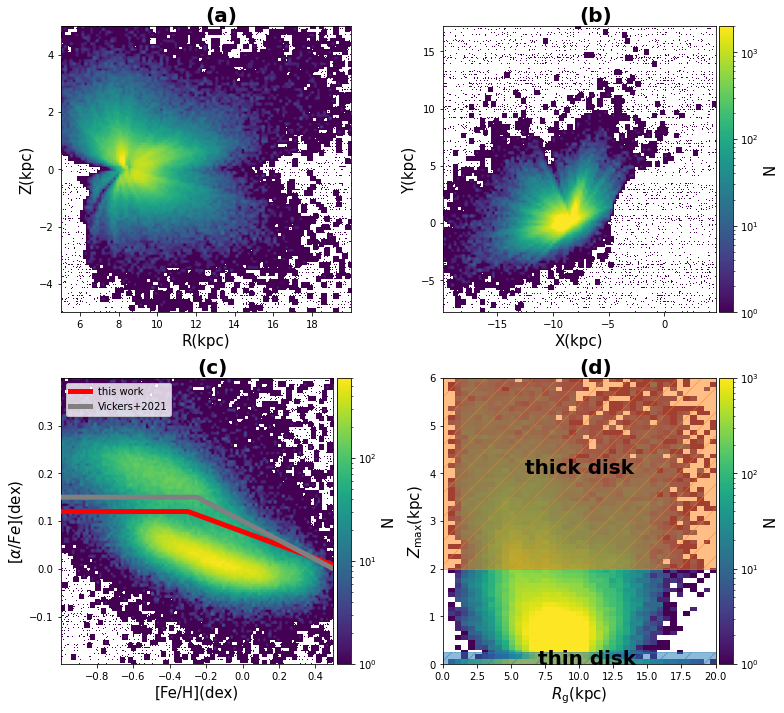

In [10]:
font = {'size':15}
font1 = {'size':20,'fontweight':'bold','color':'red'}
font2 = {'size':20,'fontweight':'bold'}
title_font={'fontsize':15,'fontweight':'bold'}
label_font={'fontsize':12}

fig,axes = plt.subplots(2,2,figsize=(11,10))
im0=hist2d(fig,axes[0,0],data[np.abs(data['z'])<5]['R'],data[np.abs(data['z'])<5]['z'],data[np.abs(data['z'])<5]['z'],stat='count',lognorm=True,vmin=1,vmax=2e3)
im1=hist2d(fig,axes[0,1],data['x'],data['y'],data['y'],stat='count',lognorm=True,vmin=1,vmax=2e3)
im2=hist2d(fig,axes[1,0],data['FEH_APOGEE'],data['AFE_APOGEE'],data['AFE_APOGEE'],stat='count',lognorm=True,vmin=1,vmax=6e2)
im3=hist2d(fig,axes[1,1],data[data['zmax']<10]['rg'],data[data['zmax']<10]['zmax'],data[data['zmax']<10]['zmax'],stat='count',lognorm=True,vmin=1,vmax=1e3);

divider = make_axes_locatable(axes[0,1])
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = fig.colorbar(im1,ax=axes[0,1],shrink=0.8,norm=mpl.colors.LogNorm(vmin=1,vmax=2e3),
                                cax=cax,orientation = 'vertical')
cbar.set_label("N",fontdict=font)

divider = make_axes_locatable(axes[1,0])
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = fig.colorbar(im2,ax=axes[1,0],shrink=0.8,norm=mpl.colors.LogNorm(vmin=1,vmax=4e2),
                                cax=cax,orientation = 'vertical')
cbar.set_label("N",fontdict=font)

divider = make_axes_locatable(axes[1,1])
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = fig.colorbar(im3,ax=axes[1,1],shrink=0.8,norm=mpl.colors.LogNorm(vmin=1,vmax=1e3),
                                cax=cax,orientation = 'vertical')
cbar.set_label("N",fontdict=font)
panels = ['(a)','(b)','(c)','(d)']
for i,ax in enumerate(axes.flatten()):
    ax.text(0.5,1.015,panels[i],transform=ax.transAxes,fontdict=font2)
    if i ==0:
        ax.set_xlabel("R(kpc)",fontdict=font)
        ax.set_ylabel("Z(kpc)",fontdict=font)
    if i ==1:
        ax.set_xlabel("X(kpc)",fontdict=font)
        ax.set_ylabel("Y(kpc)",fontdict=font)
    if i ==2:
        ax.set_xlabel('[Fe/H](dex)',fontdict=font)
        ax.set_ylabel("$[\\alpha/Fe]$(dex)",fontdict=font)
        x = np.linspace(data['FEH_APOGEE'].min(),data['FEH_APOGEE'].max(),100)
        y = chem_select(x,a=-0.3,b=0.12,k=-0.14)
        y2=chem_select(x,a=-0.25,b=0.15,k=-0.1/0.5)
        ax.plot(x,y,lw=5,zorder=10,color='red',label='this work')
        ax.plot(x,y2,lw=5,zorder=10,color='grey',label='Vickers+2021')
        ax.legend(loc='upper left')
    if i ==3:
        ax.set_xlim([0,20])
        ax.set_ylim(0,6)
        ax.set_xlabel('$R_\mathrm{g}$(kpc)',fontdict=font)
        ax.set_ylabel("$Z_\mathrm{max}$(kpc)",fontdict=font)
        ax.text(6,4,"thick disk",font2,color="black",zorder=10)
        ax.text(7,0,"thin disk",font2,color='black',zorder=10)
        ax.fill_between([0,20],[0,0],[0.25,0.25],hatch='/',alpha=.5,color='C0')
        ax.fill_between([0,20],[2,2],[6,6],hatch='/',alpha=.5,color='C1')
fig.tight_layout()
fig.savefig("distributions.jpeg",dpi=300)

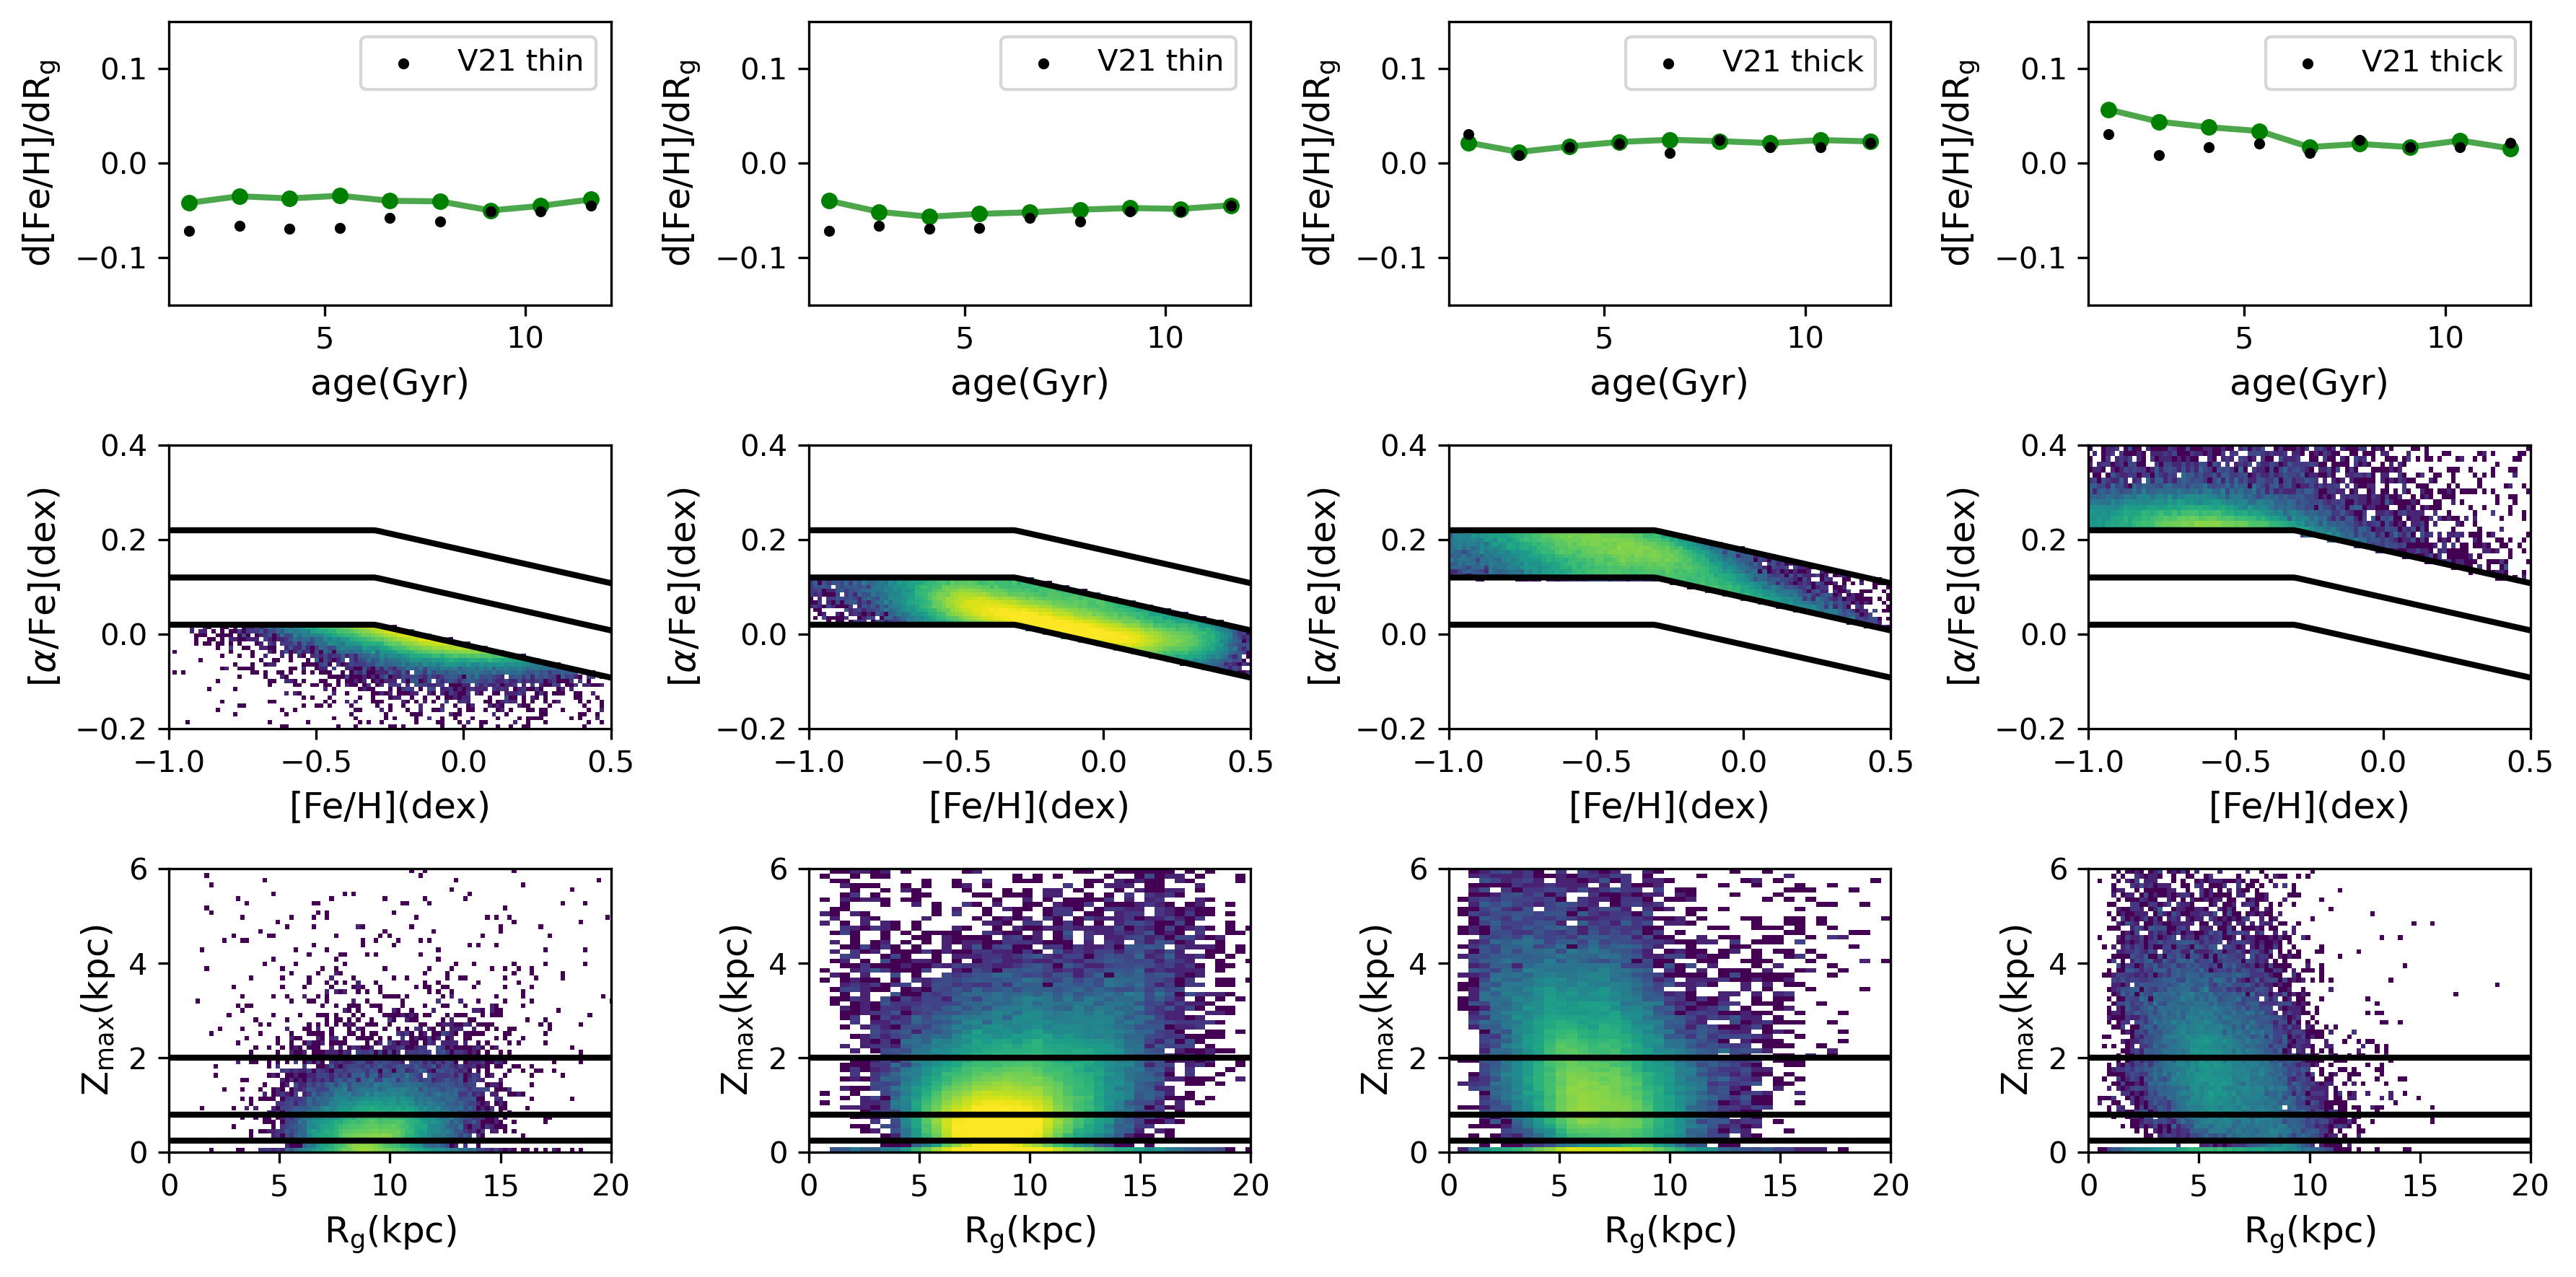

In [55]:
mpl.rcParams['figure.dpi']=300
chemical_cuts = [-np.inf, -0.1, 0, 0.1, np.inf]
agebin = np.linspace(1,12.25,10,endpoint=True)
age_binedge = (agebin[:-1] + agebin[1:])/2
feh_ = np.linspace(-1, .5, 100)
z_cuts = [0, 0.25, 0.8, 2, 6]
def selection_d(feh, alphafe):
    d = alphafe - 0.12 * bool(feh < -.3) - (-0.14 * (feh+0.3) + 0.12) * bool(feh >= -.3)
    return d
def selection_d1(feh):
    if feh < -.3:
        return 0.12
    else:
        return -0.14*(feh+0.3) + 0.12
selection_d = np.vectorize(selection_d)
selection_d1 = np.vectorize(selection_d1)
alphafe_ = selection_d1(feh_)


fig, axes=plt.subplots(3, 4,figsize=(12, 6))
    #def gradient_cal(data,rg_name, feh_name, age_name,erg_name=None, efeh_name=None):
for i in range(4):
    D_i = data[(selection_d(data["FEH_APOGEE"], data['AFE_APOGEE'])>chemical_cuts[i] ) & (selection_d(data["FEH_APOGEE"], data['AFE_APOGEE'])<chemical_cuts[i+1])]
    meta_gradients, _, error_meta_gra = gradient_cal(D_i,rg_name='rg', feh_name='FEH_APOGEE', age_name='age',erg_name='erg',efeh_name='err_feh_apogee')
    axes[0, i].errorbar(age_binedge, meta_gradients, yerr=error_meta_gra, fmt='.g', lw=2,ms=9,)
    axes[0, i].plot(age_binedge, meta_gradients, color ='green', lw=2, alpha=0.7)
    axes[0, i].set_ylim([-0.15, .15])
    axes[0, i].set_xlabel("age(Gyr)",fontdict=label_font)
    axes[0, i].set_ylabel('d[Fe/H]/dR$_{\mathrm{g}}$',fontdict=label_font)
    hist2d(fig,axes[1,i],D_i['FEH_APOGEE'],D_i['AFE_APOGEE'],D_i['AFE_APOGEE'],stat='count',lognorm=True,vmin=1,vmax=6e2,ybin=25)

    axes[1, i].plot(feh_, alphafe_, color='black', linewidth=2)
    axes[1, i].plot(feh_, alphafe_ - .1, color='black', linewidth=2)
    axes[1, i].plot(feh_, alphafe_ + .1, color='black', linewidth=2)
    axes[1, i].set_ylim([-.2, .4])
    axes[1, i].set_xlim([-1, .5])
    axes[1, i].set_xlabel('[Fe/H](dex)',fontdict=label_font)
    axes[1, i].set_ylabel("[$\\alpha$/Fe](dex)",fontdict=label_font)
    if i < 2:
        hist2d(fig,axes[2,i],D_i[D_i['zmax']<10]['rg'],D_i[D_i['zmax']<10]['zmax'],D_i[D_i['zmax']<10]['zmax'],stat='count',lognorm=True,vmin=1,vmax=1e3);
        axes[0, i].scatter(age_binedge, john_result0,s=7, color='black',zorder=10,label='V21 thin')
    else:
        hist2d(fig,axes[2,i],D_i[D_i['zmax']<10]['rg'],D_i[D_i['zmax']<10]['zmax'],D_i[D_i['zmax']<10]['zmax'],stat='count',lognorm=True,vmin=1,vmax=1e3);
        axes[0, i].scatter(age_binedge, john_result1,s=7, color='black',zorder=10,label='V21 thick')
    axes[2, i].set_xlim([0, 20])
    axes[2, i].set_ylim([0, 6]);
    axes[2, i].set_xlabel('R$_{\mathrm{g}}$(kpc)',fontdict=label_font)
    axes[2, i].set_ylabel('Z$_{\mathrm{max}}$(kpc)',fontdict=label_font)
    for j in range(3):
        axes[2, i].hlines(z_cuts[j+1], 0, 20, color='black', linewidth=2)
    axes[0, i].legend(fontsize=10)
plt.tight_layout();
fig.savefig('chemsubdiv.jpeg',dpi=300)

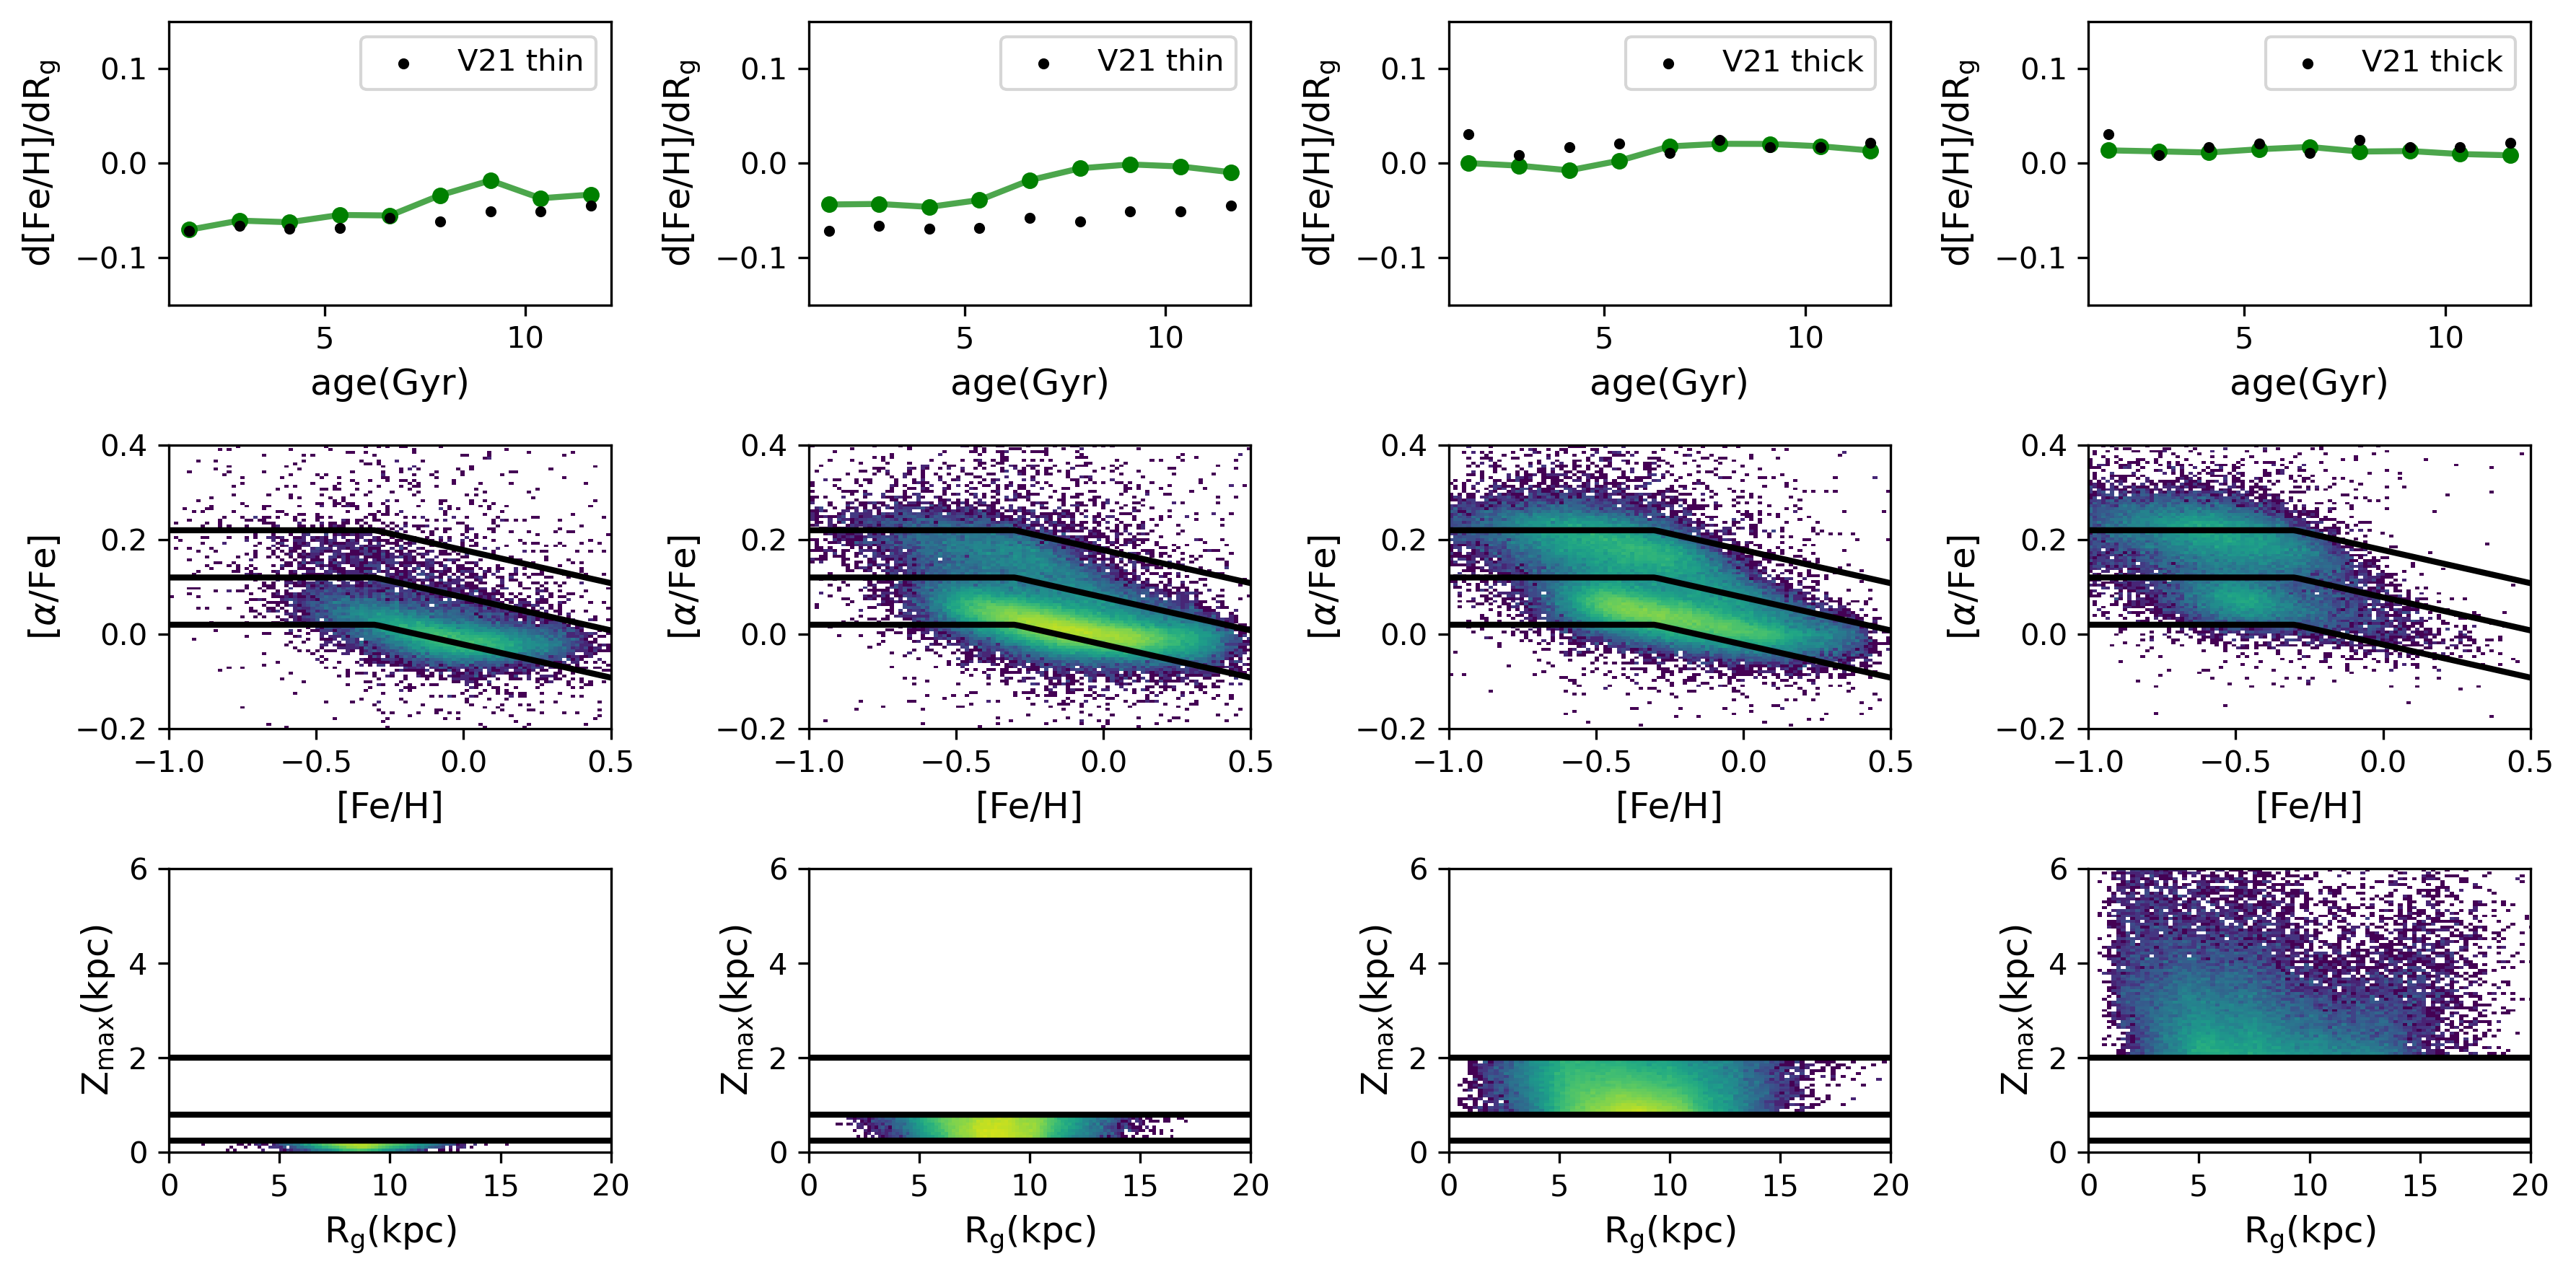

In [56]:
fig, axes=plt.subplots(3, 4,figsize=(12, 6))
    #def gradient_cal(data,rg_name, feh_name, age_name,erg_name=None, efeh_name=None):
for i in range(4):
    D_i = data[(data['zmax']>z_cuts[i] ) & (data['zmax']< z_cuts[i+1])]
    meta_gradients, _, error_meta_gra = gradient_cal(D_i,rg_name='rg', feh_name='FEH_APOGEE', age_name='age',erg_name='erg',efeh_name='err_feh_apogee')
    axes[0, i].errorbar(age_binedge, meta_gradients, yerr=error_meta_gra, fmt='.g', lw=2,ms=9,)
    axes[0, i].plot(age_binedge, meta_gradients, color ='green', lw=2, alpha=0.7)
    axes[0, i].set_ylim([-0.15, .15])
    axes[0, i].set_xlabel("age(Gyr)",fontdict=label_font)
    axes[0, i].set_ylabel('d[Fe/H]/dR$_{\mathrm{g}}$',fontdict=label_font)
    hist2d(fig,axes[1,i],D_i['FEH_APOGEE'],D_i['AFE_APOGEE'],D_i['AFE_APOGEE'],stat='count',lognorm=True,vmin=1,vmax=6e2)
    axes[1, i].plot(feh_, alphafe_, color='black', linewidth=2)
    axes[1, i].plot(feh_, alphafe_ - .1, color='black', linewidth=2)
    axes[1, i].plot(feh_, alphafe_ + .1, color='black', linewidth=2)
    axes[1, i].set_ylim([-.2, .4])
    axes[1, i].set_xlim([-1, .5])
    axes[1, i].set_xlabel('[Fe/H]',fontdict=label_font)
    axes[1, i].set_ylabel("[$\\alpha$/Fe]",fontdict=label_font)
    if i < 2:
        hist2d(fig,axes[2,i],D_i[D_i['zmax']<10]['rg'],D_i[D_i['zmax']<10]['zmax'],D_i[D_i['zmax']<10]['zmax'],stat='count',lognorm=True,vmin=1,vmax=1e3,ybin=int((z_cuts[i+1]-z_cuts[i])/6*100));
        axes[0, i].scatter(age_binedge, john_result0,s=7, color='black',zorder=10,label='V21 thin')
    else:
        hist2d(fig,axes[2,i],D_i[D_i['zmax']<10]['rg'],D_i[D_i['zmax']<10]['zmax'],D_i[D_i['zmax']<10]['zmax'],stat='count',lognorm=True,vmin=1,vmax=1e3,ybin=int((z_cuts[i+1]-z_cuts[i])/6*100));
        axes[0, i].scatter(age_binedge, john_result1,s=7, color='black',zorder=10,label='V21 thick')
    axes[2, i].set_xlim([0, 20])
    axes[2, i].set_ylim([0, 6]);
    axes[2, i].set_xlabel('R$_{\mathrm{g}}$(kpc)',fontdict=label_font)
    axes[2, i].set_ylabel('Z$_{\mathrm{max}}$(kpc)',fontdict=label_font)
    for j in range(3):
        axes[2, i].hlines(z_cuts[j+1], 0, 20, color='black', linewidth=2)
    axes[0, i].legend(fontsize=10)
plt.tight_layout();
fig.savefig('zmaxsubdiv.jpeg',dpi=300)

Text(0.5, 1.0, 'thin sample')

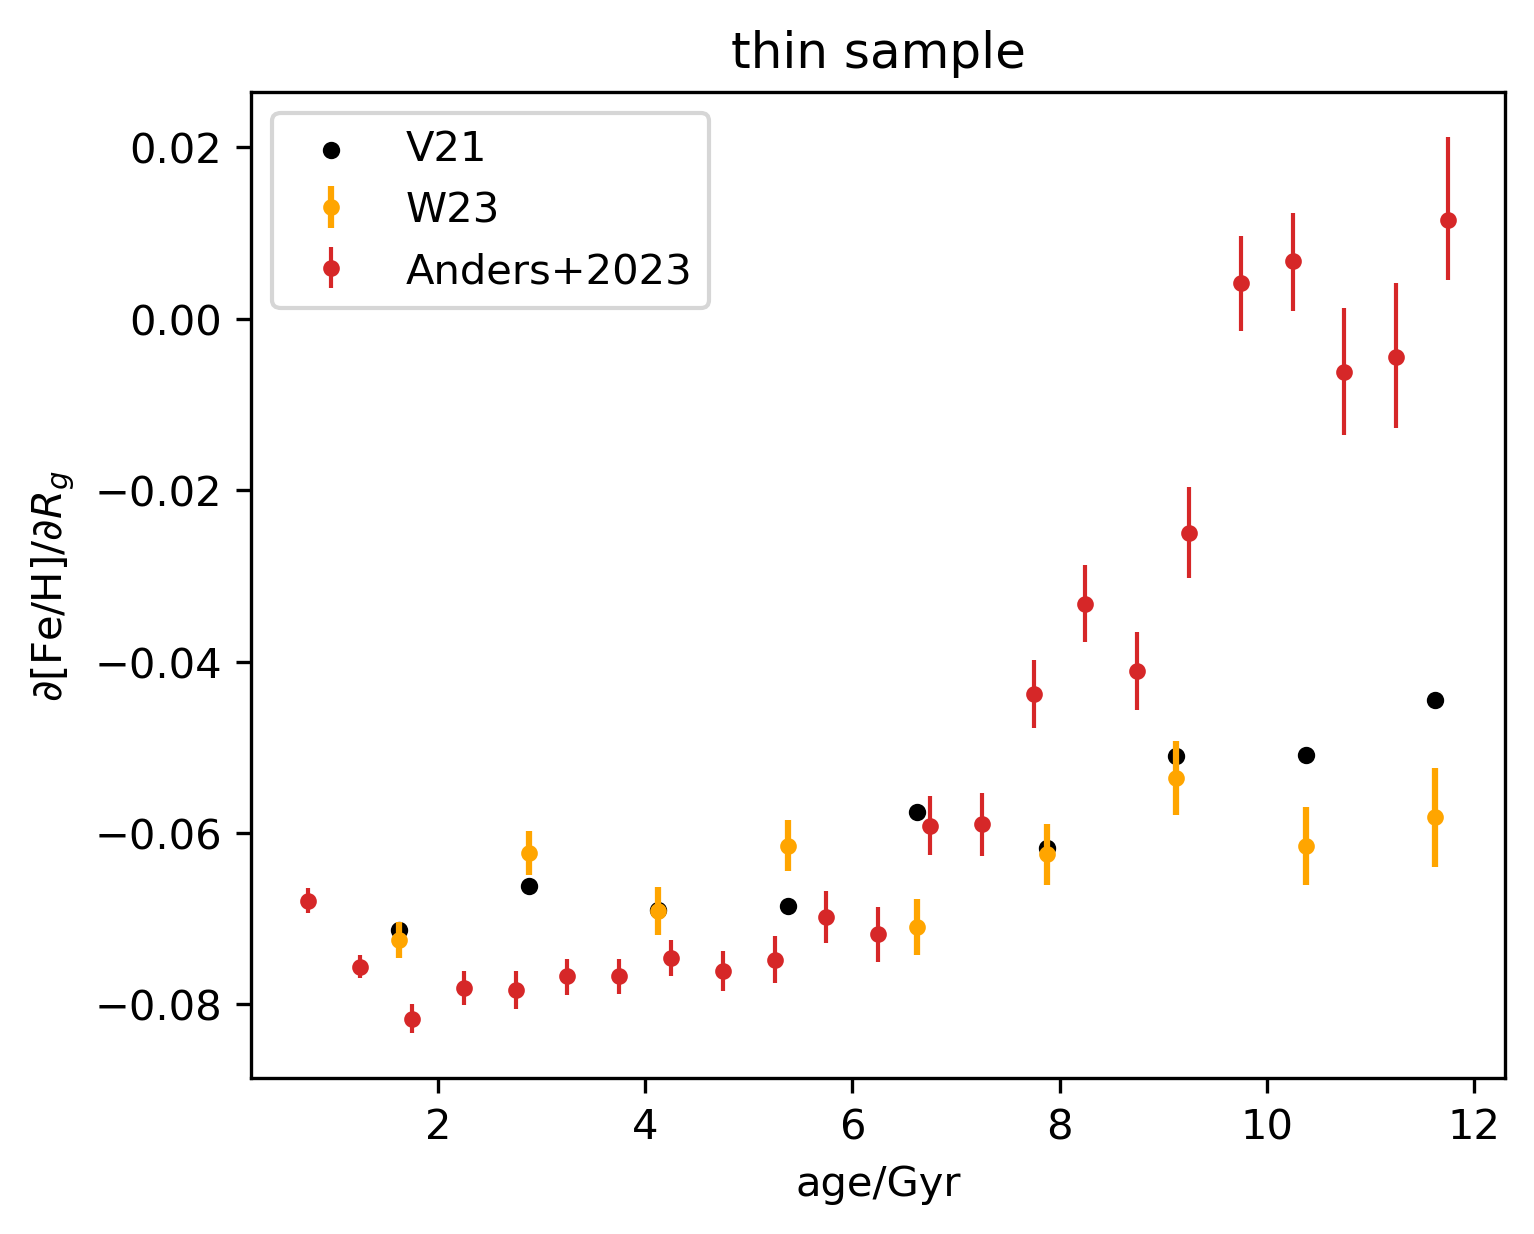

In [153]:
mpl.rcParams['figure.dpi']=300
fig,ax=plt.subplots(1,1,figsize=(5,4),constrained_layout=True)
ax.errorbar(age_binedge,thin_grad,yerr=thin_err,label='W23',fmt='.',color='orange')
#ax.errorbar(age_binedge,thin_grad[3],yerr=thin_err4,label='K23',fmt='.',color='blue')
ax.scatter(age_binedge,john_result0,label='V21',color='black',s=10)
ax.errorbar(age_anders,anders[:,0],yerr=[anders[:,1], anders[:,2]],fmt='.C3',lw=1,label='Anders+2023')
#ax.scatter(*bridget.T,s=6,color='green',zorder=5,label='Ratcliffe+2023')
ax.set_xlabel("age/Gyr")
ax.set_ylabel("$\partial$[Fe/H]/$\partial R_{g}$")
ax.legend(fontsize=10)
ax.set_title("thin sample")

NameError: name 'thin_err3' is not defined

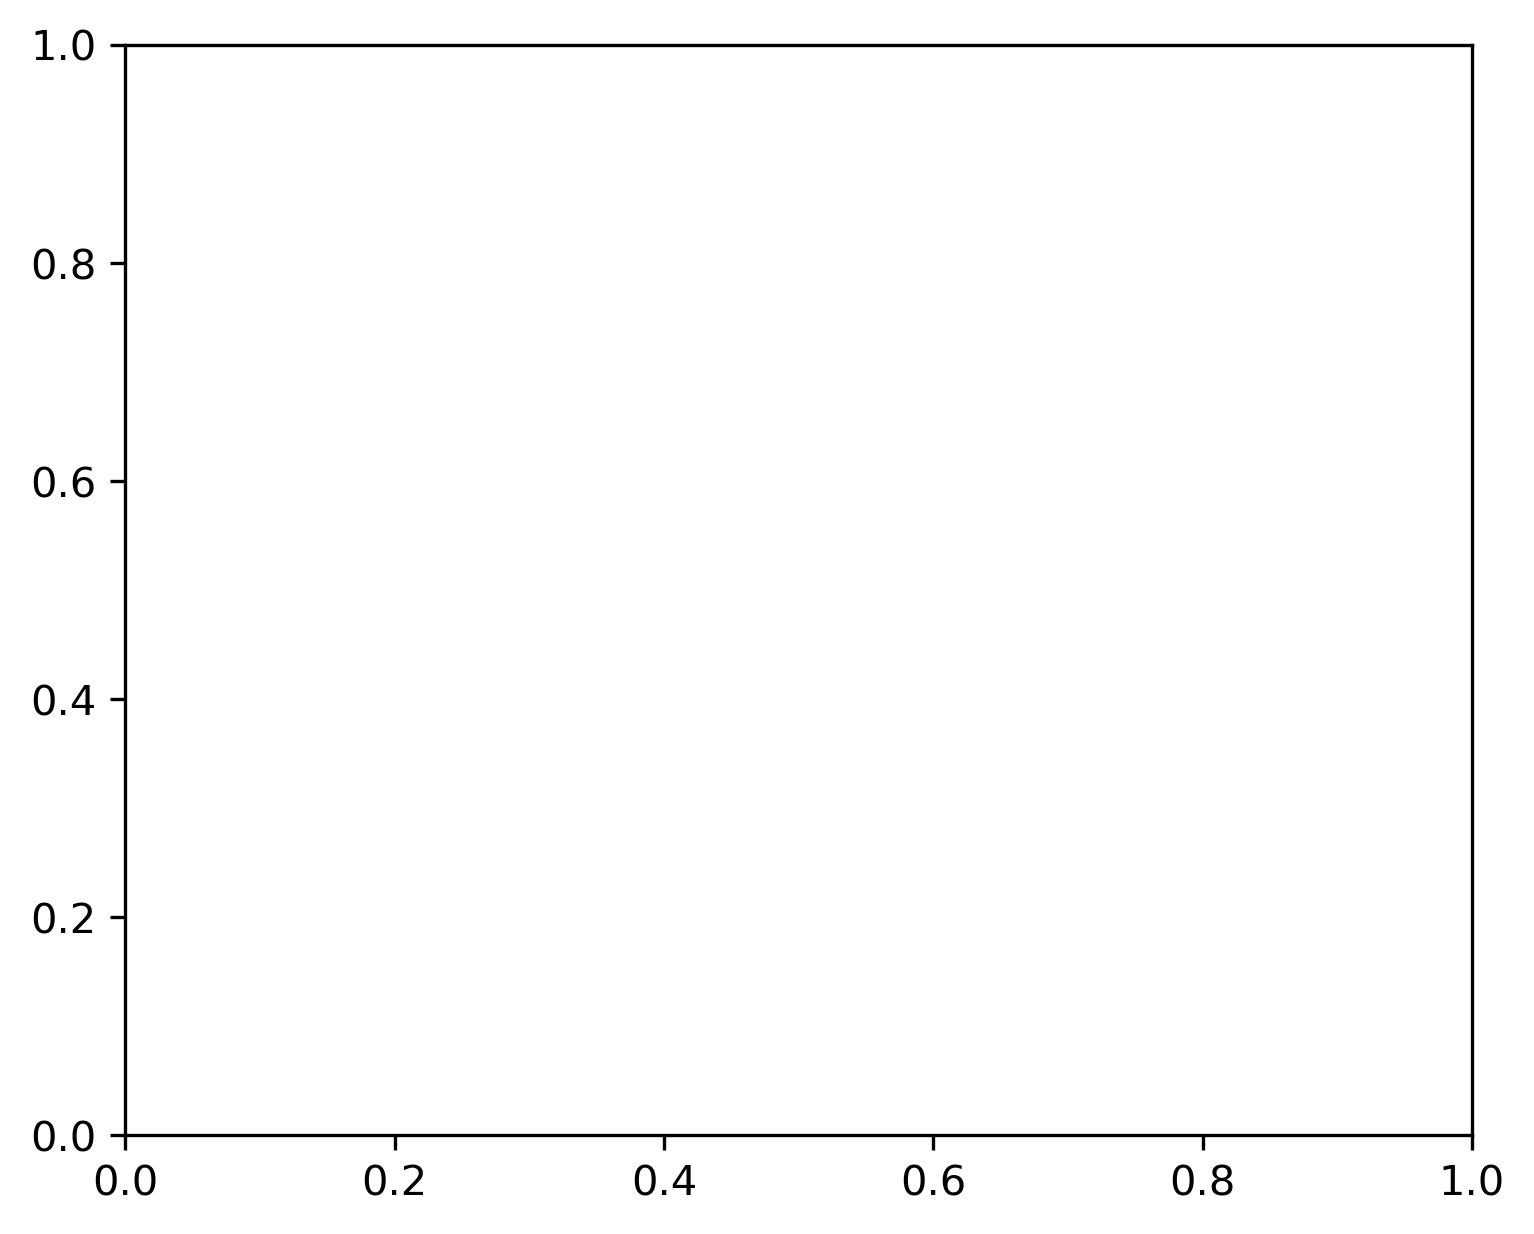

In [154]:
fig,ax=plt.subplots(1,1,figsize=(5,4),constrained_layout=True)
ax.errorbar(age_binedge,thin_grad[2],yerr=thin_err3,label='W23',fmt='.',color='orange')
#ax.errorbar(age_binedge,thin_grad[3],yerr=thin_err4,label='K23',fmt='.',color='blue')
ax.errorbar(age_binedge,thin_grad[0],yerr=thin_err1,label='V21',fmt='.',color='black')
#ax.errorbar(age_anders,anders[:,0],yerr=[anders[:,1], anders[:,2]],fmt='.C3',lw=1,label='Anders+2023')
#ax.scatter(*bridget.T,s=6,color='green',zorder=5,label='Ratcliffe+2023')
ax.set_xlabel("age/Gyr")
ax.set_ylabel("$\partial$[Fe/H]/$\partial R_{g}$")
ax.legend(fontsize=10)
ax.set_title("thin sample")

Text(0.5, 1.0, 'thin sample')

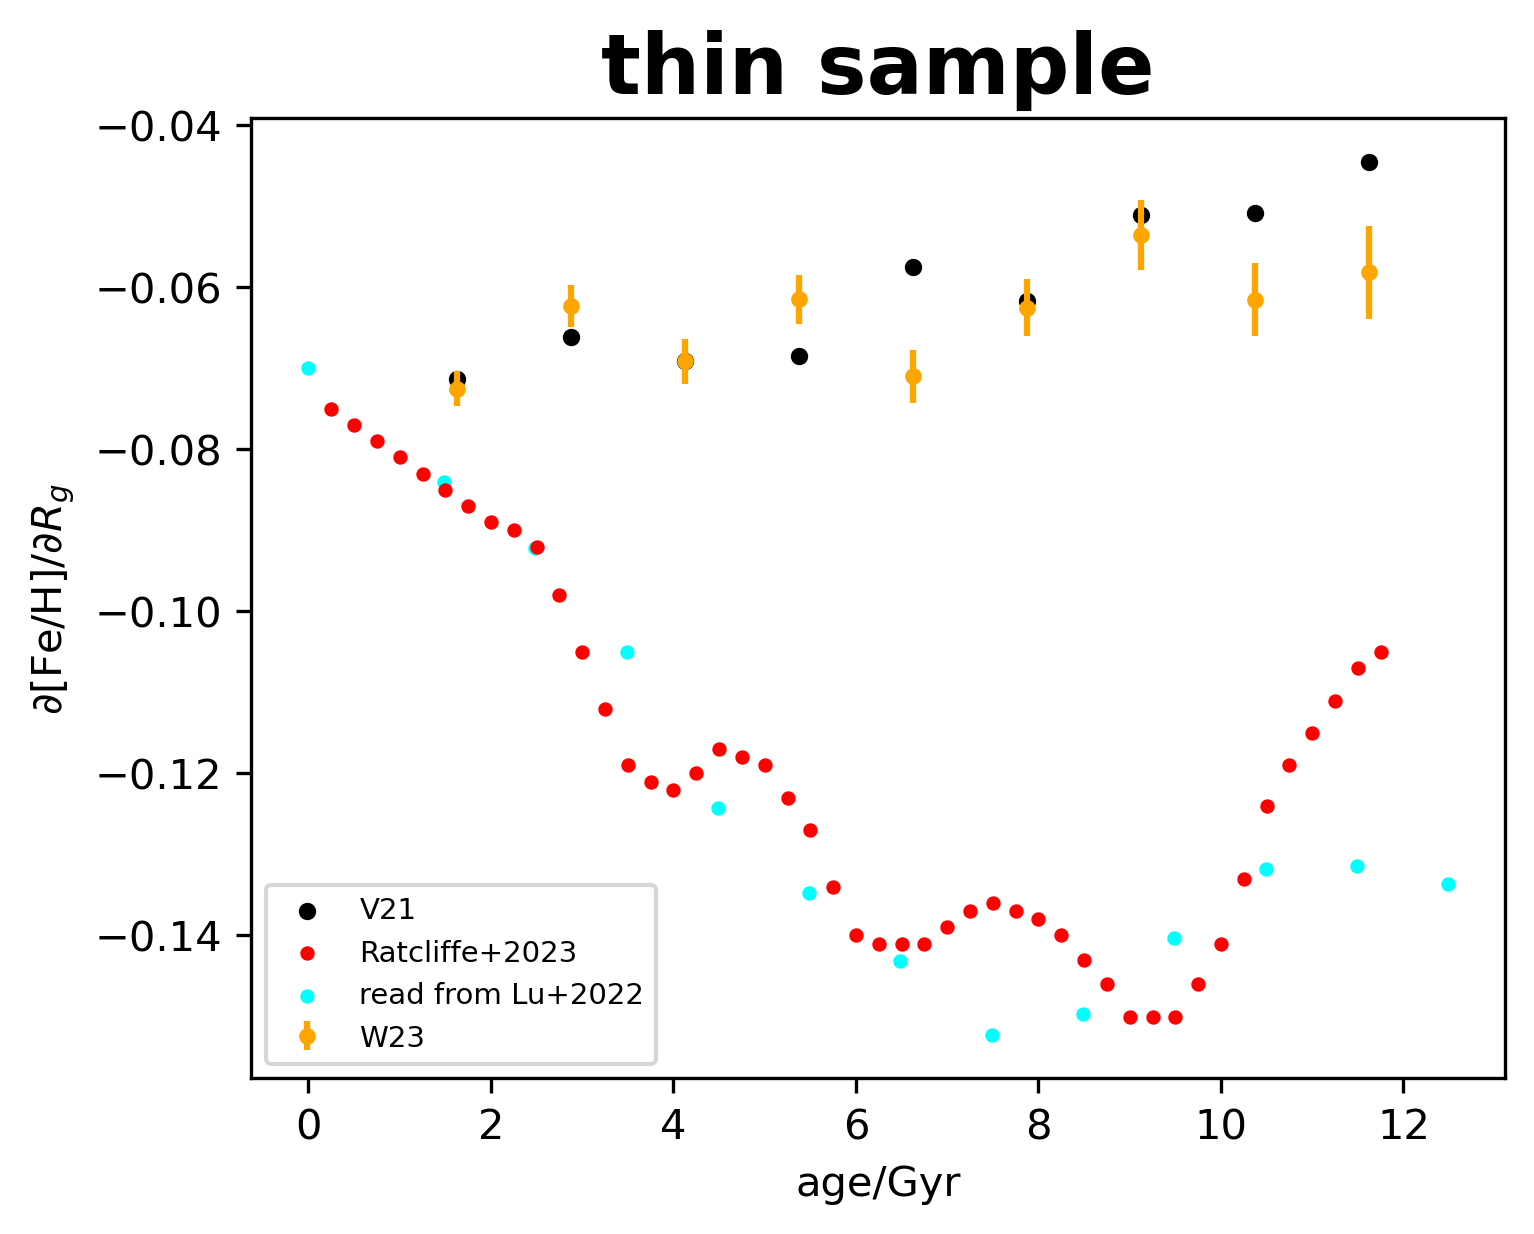

In [155]:
lu =np.array((
[
    [0,-0.07],
    [1.488,-0.084],
    [2.488,-0.0922],
    [3.488,-.105],
    [4.488,-.124286],
    [5.488,-.13476],
    [6.488,-.143175],
    [7.488,-.152222],
    [8.488,-.149683],
    [9.488,-.140317],
    [10.488,-0.131746],
    [11.488,-.131429],
    [12.488,-0.133651]
]))
fig,ax=plt.subplots(1,1,figsize=(5,4),constrained_layout=True)
ax.errorbar(age_binedge,thin_grad,yerr=thin_err,label='W23',fmt='.',color='orange')
#ax.errorbar(age_binedge,thin_grad[3],yerr=thin_err4,label='K23',fmt='.',color='blue')
ax.scatter(age_binedge,john_result0,label='V21',s=10,color='black')
#ax.errorbar(age_anders,anders[:,0],yerr=[anders[:,1], anders[:,2]],fmt='.C3',lw=1,label='Anders+2023')
ax.scatter(*bridget.T,s=6,color='red',zorder=5,label='Ratcliffe+2023')
ax.scatter(*lu.T,color='cyan',s=6,label='read from Lu+2022')
ax.set_xlabel("age/Gyr")
ax.set_ylabel("$\partial$[Fe/H]/$\partial R_{g}$")
ax.legend(fontsize=7,loc='lower left')
ax.set_title("thin sample",fontdict=font2)

Text(0.5, 1.0, 'thick sample')

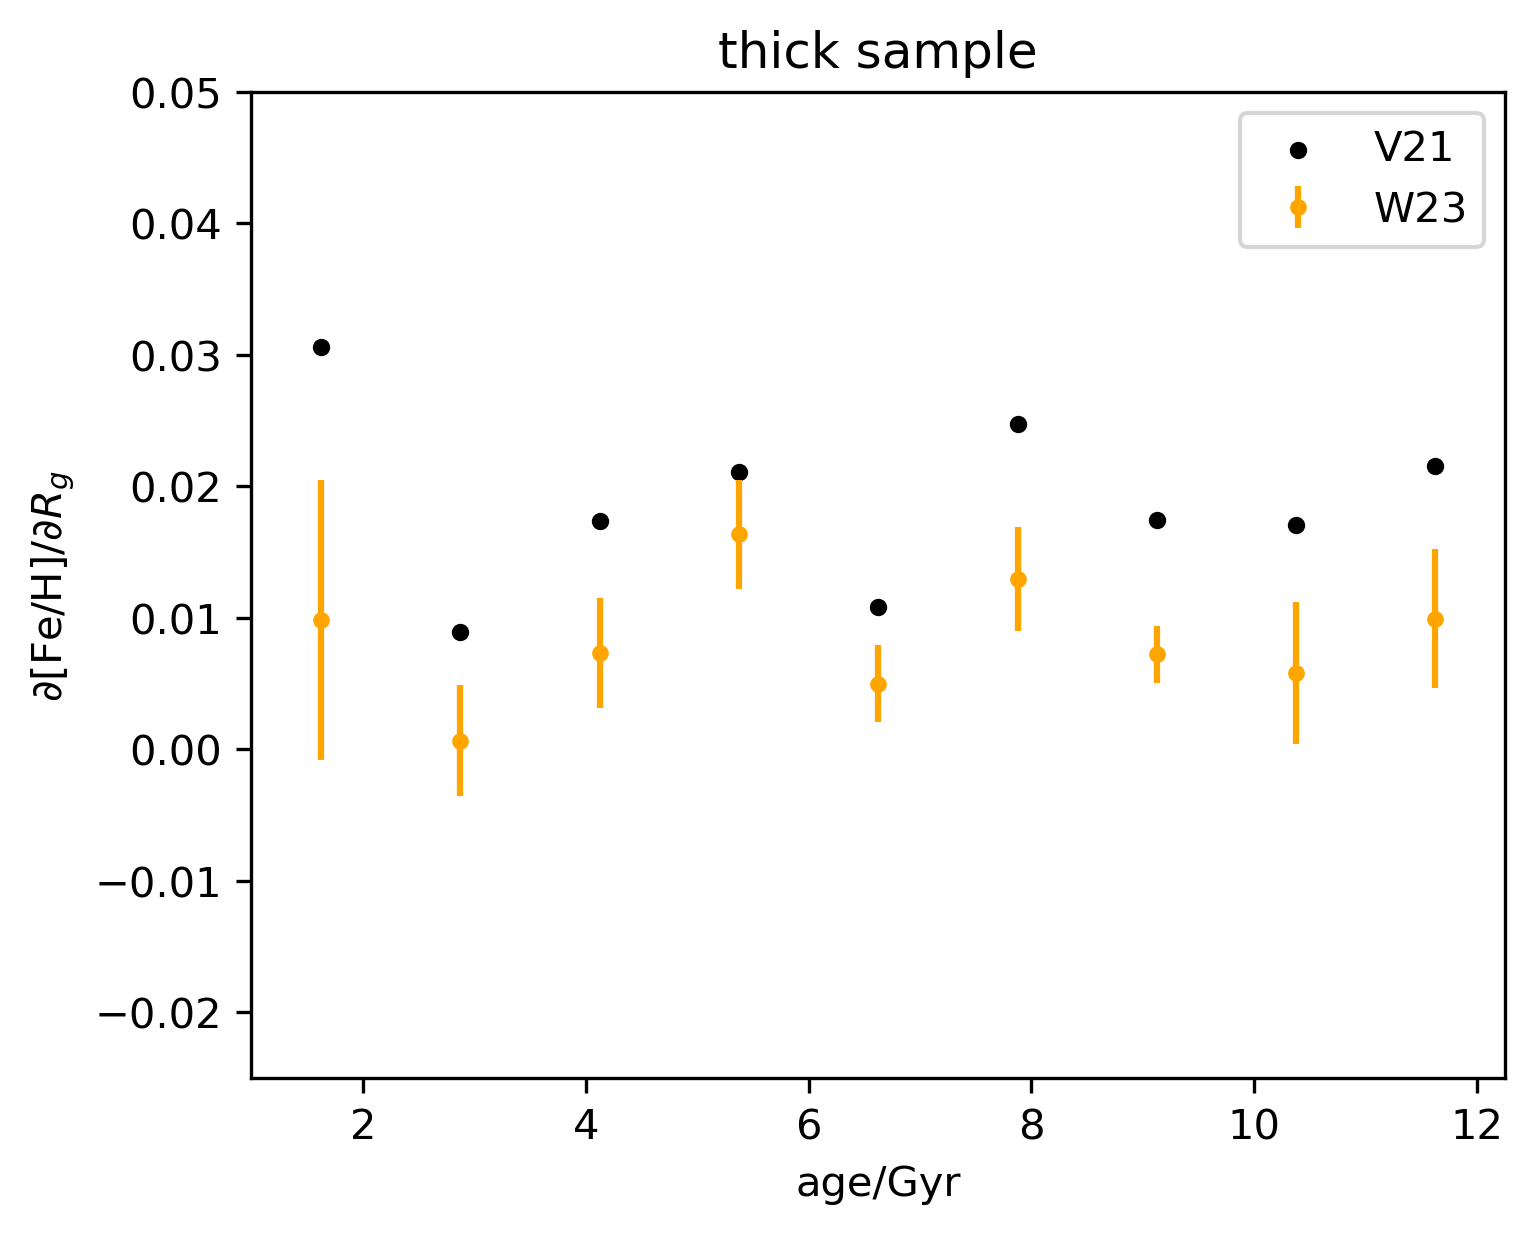

In [73]:
fig,ax=plt.subplots(1,1,figsize=(5,4),constrained_layout=True)
ax.errorbar(age_binedge,thick_grad,yerr=thick_err,label='W23',fmt='.',color='orange')
#ax.errorbar(age_binedge,thick_grad[3],yerr=thick_err4,label='K23',fmt='.',color='blue')
ax.scatter(age_binedge,john_result1,label='V21',s=10,color='black')
ax.axis([agebin[0],agebin[-1],-0.025,0.05])
ax.set_xlabel("age/Gyr")
ax.set_ylabel("$\partial$[Fe/H]/$\partial R_{g}$")
ax.legend()
ax.set_title('thick sample')

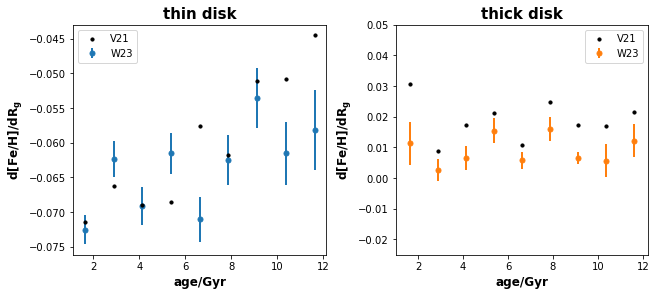

In [7]:
fig,axes,thin,thick,thin_grad,thin_b,thin_err,thick_grad,thick_b,thick_err = thin_and_thick_grad(data,data_name='W23',rg_name='rg',feh_name='FEH_APOGEE',age_name='age',erg_name='erg',afe_name='AFE_APOGEE',zmax_name='zmax',efeh_name='err_feh_apogee')
fig.savefig('result.pdf')

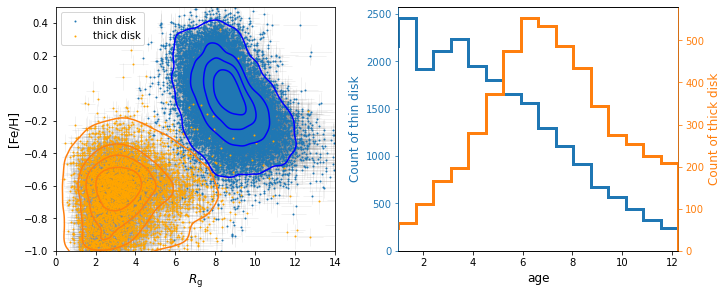

In [13]:
fig,axes=plt.subplots(1,2,figsize=(10,4),constrained_layout=True)
ax=axes[0]
ax.set_ylabel("[Fe/H]",fontdict=label_font)
ax.set_xlabel("$R_\mathrm{g}$",fontdict=label_font)
ax.errorbar(x=thin['rg'],y=thin['FEH_APOGEE'],xerr=thin['erg'],yerr=thin['err_feh_apogee'],color='C0',alpha=.2,fmt='none',elinewidth=.5,zorder=-10,ecolor='grey')
ax.errorbar(x=thick['rg'],y=thick['FEH_APOGEE'],xerr=thick['erg'],yerr=thick['err_feh_apogee'],color="orange",alpha=.2,fmt='none',elinewidth=.5,zorder=-10,ecolor='grey')
ax.scatter(x=thin['rg'],y=thin['FEH_APOGEE'],color='C0',label='thin disk',s=1)
ax.scatter(x=thick['rg'],y=thick['FEH_APOGEE'],color="orange",label='thick disk',s=1)
sns.kdeplot(x=thin['rg'],y=thin['FEH_APOGEE'],color='blue',levels=5,ax=ax)
sns.kdeplot(x=thick['rg'],y=thick['FEH_APOGEE'],color='C1',levels=5,ax=ax)
ax.set_ylim(-1,0.5)
ax.set_xlim(0,14)
ax.legend(loc='upper left')

thin_=thin[thin['age']<agebin[-1]]
thick_=thick[thick['age']<agebin[-1]]
agebins=np.linspace(min(thin_['age'].min(),thick_['age'].min()), max(thin_['age'].max(),thick_['age'].max()),40)
axes[1].hist(thin_['age'],histtype='step',density=False,bins=agebins,lw=3,label='thin disk')
axes[1].axis([agebin[0],agebin[-1],0,None])
axes[1].tick_params(axis='y',colors='C0')
axes[1].set_ylabel("Count of thin disk",color="C0",fontdict=label_font)
ax1 = axes[1].twinx()
ax1.spines['left'].set_color("C0")
ax1.hist(thick_['age'],histtype='step',density=False,bins=agebins,lw=3,label='thick disk',color='C1')
ax1.axis([agebin[0],agebin[-1],0,None])
ax1.spines['right'].set_color('C1')
ax1.tick_params(axis='y',colors='C1')
ax1.set_ylabel("Count of thick disk",color='C1',fontdict=label_font)
axes[1].set_xlabel("age",fontdict=label_font)
fig.savefig("2samples.jpeg",dpi=300)

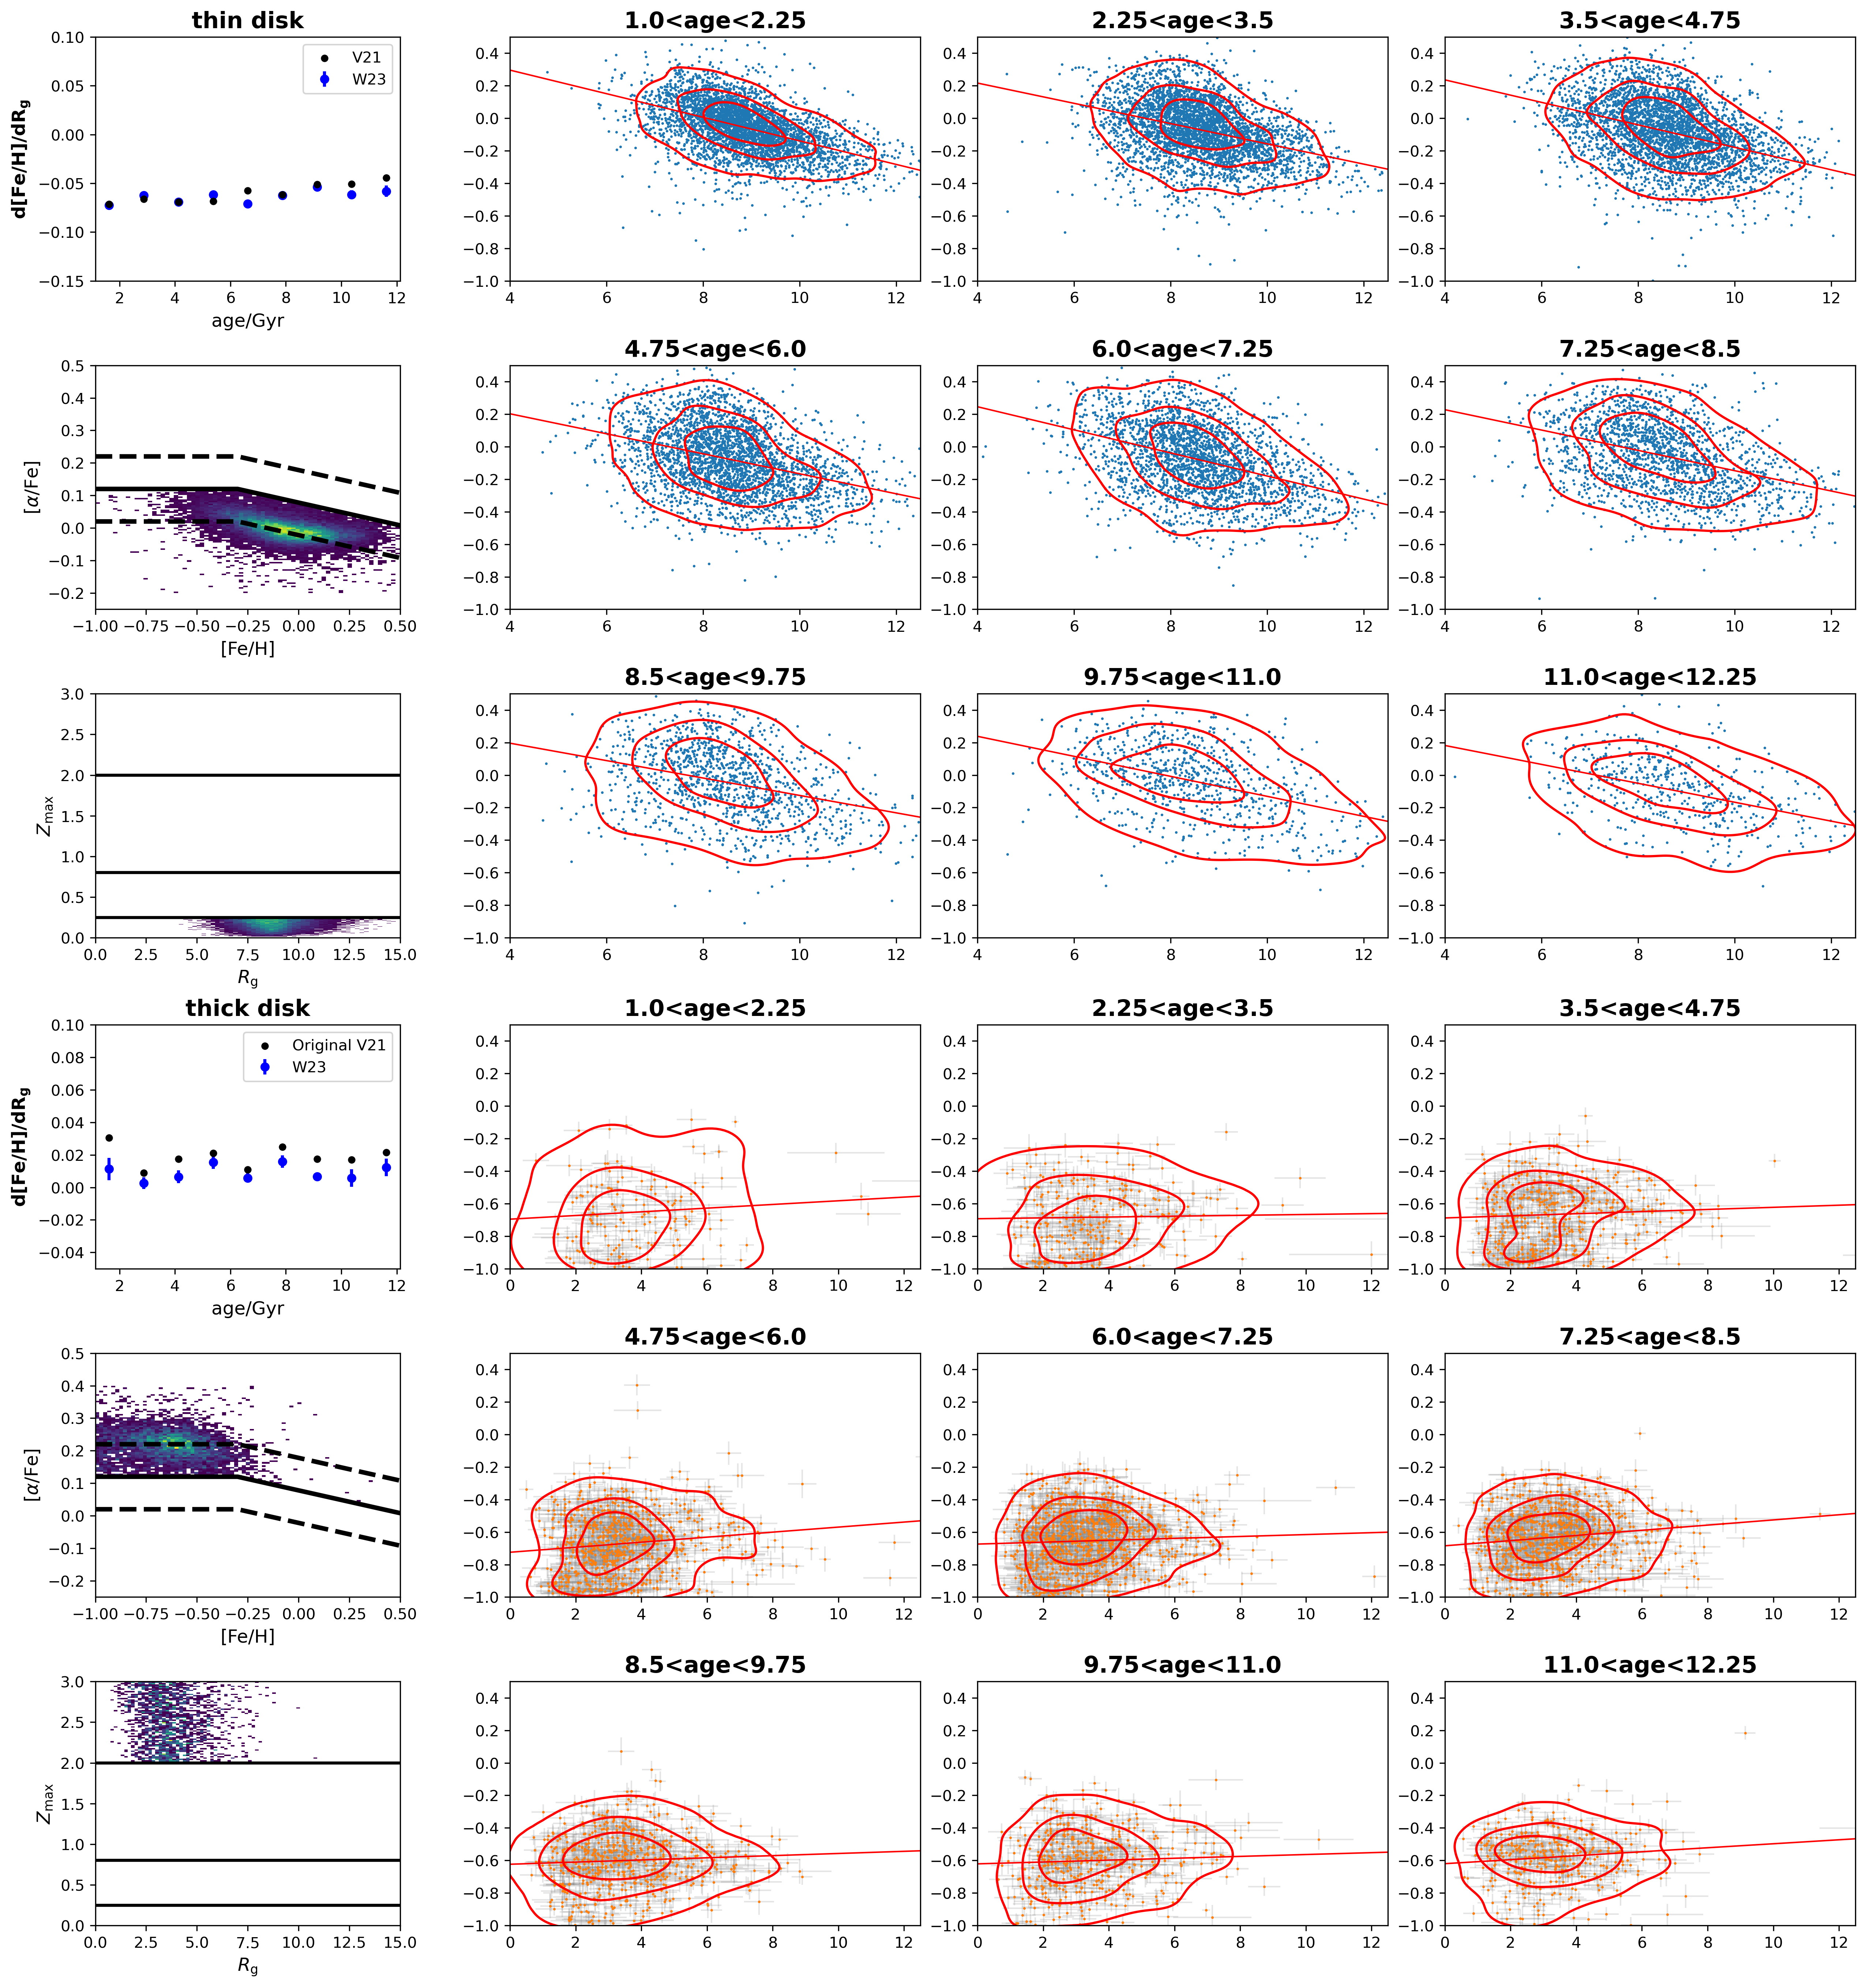

In [182]:
def scatter_feh_rg(ax,data,labels=True,**kwarg):
    ax.scatter(data['rg'].values, data['FEH_APOGEE'].values,s=.5,**kwarg)
    kde=sns.kdeplot(x=data['rg'].values, y=data['FEH_APOGEE'].values,color='red',levels=4,thresh=0.1,ax=ax)
    kde.set_xlabel('')
    kde.set_ylabel('')
    if labels:
        ax.set_xlabel("$R_g$")
        ax.set_ylabel("[Fe/H]")
x_ = np.linspace(-1,0.5,500)
z_cuts = [0, 0.25, 0.8, 2, np.inf]
rg1 = np.linspace(4,15,100)
rg2 = np.linspace(0,20,100)
lognorm=mpl.colors.LogNorm(vmin=1,vmax=1e4)

fig,axes=plt.subplots(6,4,figsize=(17,18),constrained_layout=True)
for i,ax in enumerate(axes.flatten()):
    if i == 0:
        ax.scatter(age_binedge, john_result0,s=15,color='black',zorder=10,label='V21')
        #ax.errorbar(age_anders,anders[:,0],yerr=[anders[:,1], anders[:,2]],fmt='.r',lw=1,ms=10,label='Anders+2023')
        #ax.scatter(*bridget.T,s=15,color='green',zorder=5,label='Ratcliffe+2023')
        ax.set_xlabel("age/Gyr",fontdict=label_font)
        ax.set_ylabel("$\mathbf{\mathbf{d}[Fe/H]/\mathbf{d}R_g}$",fontdict=label_font)
        ax.set_ylim(-0.15,.1)
        ax.set_xlabel("age/Gyr",fontdict=label_font)
        ax.set_ylabel("$\mathbf{\mathbf{d}[Fe/H]/\mathbf{d}R_g}$",fontdict=label_font)
        ax.errorbar(age_binedge,thin_grad,yerr=thin_err,fmt='.b',lw=2,ms=10,label='W23')
        ax.set_title("thin disk",fontdict=title_font)
        ax.legend()
    elif i == 4:
        ax.hist2d(thin['FEH_APOGEE'],thin["AFE_APOGEE"],cmin=1,bins=(70,70),cmap='viridis');
        ax.plot(x_,chem_select(x_,a=-0.3,b=.12,k=-.14),color='black',linestyle='-',lw=3)
        ax.plot(x_,chem_select(x_,a=-0.3,b=.12,k=-.14)+0.1,color='black',linestyle='--',lw=3)
        ax.plot(x_,chem_select(x_,a=-0.3,b=.12,k=-.14)-0.1,color='black',linestyle='--',lw=3)
        ax.axis([-1,0.5,-0.25,0.5])
        ax.set_xlabel("[Fe/H]",fontdict=label_font)
        ax.set_ylabel("[$\\alpha$/Fe]",fontdict=label_font)
    elif i == 8:
        ax.hist2d(thin[thin['zmax']<3]['rg'],thin[thin['zmax']<3]['zmax'],cmin=1,bins=(60,60),cmap='viridis');
        for j in range(3):
            ax.hlines(z_cuts[j+1], 0, 15, color='black', lw=2)
        ax.axis([0,15,0,3])
        ax.set_xlabel("$R_\mathrm{g}$",fontdict=label_font)
        ax.set_ylabel("$Z_\mathrm{max}$",fontdict=label_font)
    elif i==12:
        ax.scatter(age_binedge, john_result1,s=15,color='black',zorder=10,label='Original V21')
        ax.set_xlabel("age/Gyr",fontdict=label_font)
        ax.set_ylabel("$\mathbf{\mathbf{d}[Fe/H]/\mathbf{d}R_g}$",fontdict=label_font)
        ax.set_ylim(-0.05,.1)
        ax.set_xlabel("age/Gyr",fontdict=label_font)
        ax.set_ylabel("$\mathbf{\mathbf{d}[Fe/H]/\mathbf{d}R_g}$",fontdict=label_font)
        ax.errorbar(age_binedge,thick_grad,yerr=thick_err,fmt='.b',lw=2,ms=10,label='W23')
        ax.set_title("thick disk",fontdict=title_font)
        ax.legend()
    elif i == 16:
        ax.hist2d(thick['FEH_APOGEE'],thick["AFE_APOGEE"],cmin=1,bins=(70,70),cmap='viridis');
        ax.plot(x_,chem_select(x_,a=-0.3,b=.12,k=-.14),color='black',linestyle='-',lw=3)
        ax.plot(x_,chem_select(x_,a=-0.3,b=.12,k=-.14)+0.1,color='black',linestyle='--',lw=3)
        ax.plot(x_,chem_select(x_,a=-0.3,b=.12,k=-.14)-0.1,color='black',linestyle='--',lw=3)
        ax.axis([-1,0.5,-0.25,0.5])
        ax.set_xlabel("[Fe/H]",fontdict=label_font)
        ax.set_ylabel("[$\\alpha$/Fe]",fontdict=label_font)
    elif i == 20:
        ax.hist2d(thick[thick['zmax']<3]['rg'],thick[thick['zmax']<3]['zmax'],cmin=1,bins=(60,60),cmap='viridis');
        for j in range(3):
            ax.hlines(z_cuts[j+1], 0, 15, color='black', lw=2)
        ax.axis([0,15,0,3])
        ax.set_xlabel("$R_\mathrm{g}$",fontdict=label_font)
        ax.set_ylabel("$Z_\mathrm{max}$",fontdict=label_font)
    elif 0<i<12:
        data_=thin
        data_age_bined = data_[(data_['age']>agebin[i-1*(i//4)-1])&(data_['age']<agebin[i-1*(i//4)])]
        scatter_feh_rg(ax,data_age_bined,labels=False,**{"color":"C0"})
        ax.errorbar(x=data_age_bined['rg'].values,y=data_age_bined['rg'].values,xerr=data_age_bined['erg'].values,
                            yerr=data_age_bined['err_feh_apogee'].values,
                           alpha=.2,fmt='none',elinewidth=1,zorder=-10,ecolor='grey')
        ax.plot(rg1, thin_grad[i-1*(i//4)-1]*rg1+thin_b[i-1*(i//4)-1],lw=1,c='red')
        ax.set_ylim(-1,.5)
        ax.set_xlim(4,12.5)
        ax.set_title(f"{agebin[i-1*(i//4)-1]}<age<{agebin[i-1*(i//4)]}",fontdict=title_font)
    elif 12<i<24:
        data_=thick
        data_age_bined = data_[(data_['age']>agebin[i-1*((i-12)//4)-13])&(data_['age']<agebin[i-12-1*((i-12)//4)])]
        scatter_feh_rg(ax,data_age_bined,labels=False,**{"color":"C1"})
        ax.errorbar(x=data_age_bined['rg'].values,y=data_age_bined['FEH_APOGEE'].values,xerr=data_age_bined['erg'].values,
                            yerr=data_age_bined['err_feh_apogee'].values,
                           alpha=.2,fmt='none',elinewidth=1,zorder=-10,ecolor='grey')
        ax.plot(rg2, thick_grad[i-1*((i-12)//4)-13]*rg2+thick_b[i-1*((i-12)//4)-13],lw=1,c='red')
        ax.set_ylim(-1,.5)
        ax.set_xlim(0,12.5)
        ax.set_title(f"{agebin[i-1*((i-12)//4)-13]}<age<{agebin[i-1*((i-12)//4)-12]}",fontdict=title_font)
    if i%4==0:
        ax.set_box_aspect(0.8)
    #fig.savefig(f'detailed grad of {titles[idx]}_v1.jpeg',dpi=300)

In [183]:
fig.savefig("detail.jpeg",dpi=300)

In [164]:
len(thick)

2569

In [163]:
len(thin)

13148

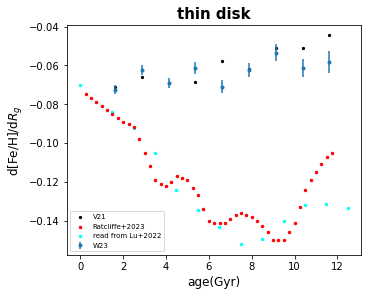

In [20]:
lu =np.array((
[
    [0,-0.07],
    [1.488,-0.084],
    [2.488,-0.0922],
    [3.488,-.105],
    [4.488,-.124286],
    [5.488,-.13476],
    [6.488,-.143175],
    [7.488,-.152222],
    [8.488,-.149683],
    [9.488,-.140317],
    [10.488,-0.131746],
    [11.488,-.131429],
    [12.488,-0.133651]
]))
fig,ax=plt.subplots(1,1,figsize=(5,4),constrained_layout=True)
ax.errorbar(age_binedge,thin_grad,yerr=thin_err,label='W23',fmt='.',color='C0')
#ax.errorbar(age_binedge,thin_grad[3],yerr=thin_err4,label='K23',fmt='.',color='blue')
ax.scatter(age_binedge,john_result0,label='V21',color='black',s=5)
#ax.errorbar(age_anders,anders[:,0],yerr=[anders[:,1], anders[:,2]],fmt='.C3',lw=1,label='Anders+2023')
ax.scatter(*bridget.T,s=6,color='red',zorder=5,label='Ratcliffe+2023')
ax.scatter(*lu.T,color='cyan',s=6,label='read from Lu+2022')
ax.set_xlabel("age(Gyr)",fontdict=label_font)
ax.set_ylabel("$\mathrm{d}$[Fe/H]/$\mathrm{d} R_{g}$",fontdict=label_font)
ax.legend(fontsize=7,loc='lower left')
ax.set_title("thin disk",fontdict=title_font)
fig.savefig("thin sample_v2.pdf")